### Variable Consistency Check

This notebook performs a **structural consistency audit** across all decoded survey files to identify variables that are **present in every survey month** from 2018 to 2024.

It follows the duplicate resolution and renaming step (`Duplicate_Handler.ipynb`) and serves as a **precondition for imputation**.

---
Purpose
- Identify variables that are **structurally consistent** across all survey waves.
- Prevent imputation on variables that were **not collected** in certain months.
- Provide a **presence matrix** and a **consistency profile** to guide downstream imputation and modeling.
---
Input
- Folder: `NEW Renamed Fully Decoded Surveys`  
(This folder contains harmonized survey files with duplicates already resolved.)

Output

- Folder: `NEW Variable Consistency Check`
 - `presence_matrix.csv`: binary matrix of variable presence across months
 - `consistency_profile.csv`: summary of variable presence rates and consistency tags

---

Consistency Criteria

A variable is considered **consistent** if it is present in **all survey months from 2018 to 2024**.  
Variables with partial presence are flagged as `partial` or `inconsistent` depending on their coverage.

This ensures that imputation is only applied to variables that were **intended to be collected** throughout the full time span.

In [1]:
import json
from pathlib import Path
import os
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# Load config
with open(Path("./data/interim/config.json")) as f:
    cfg = json.load(f)

BASE_PATH = Path(cfg["BASE_PATH"])
INTERIM_DIR = Path(cfg["INTERIM_DIR"])
PROCESSED_DIR = Path(cfg["PROCESSED_DIR"])
LOG_DIR = Path(cfg["LOG_DIR"])
MONTH_ORDER = cfg["MONTH_ORDER"]

# Load inventory
with open(Path(INTERIM_DIR) / "inventory.json") as f:
    inventory = json.load(f)

In [2]:
import shutil

# Input and output folders
input_root = BASE_PATH / "NEW Renamed Fully Decoded Surveys"
output_root = BASE_PATH / "NEW Variable Consistency Check"

# --- NEW: IDEMPOTENT FOLDER CLEANUP ---
# This wipes out any "consistency_profile(1).csv" ghost files from previous runs
if output_root.exists():
    print(f" Cleaning existing consistency report folder: {output_root}")
    shutil.rmtree(output_root)

output_root.mkdir(parents=True, exist_ok=True)

print(f"Input folder: {input_root}")
print(f"Output folder created/verified: {output_root}")

 Cleaning existing consistency report folder: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\NEW Variable Consistency Check
Input folder: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\NEW Renamed Fully Decoded Surveys
Output folder created/verified: H:\.shortcut-targets-by-id\1VctTphaltRx4xcPxmTJlRTrxLalyuEt8\Labor Force Survey\NEW Variable Consistency Check


In [3]:
# Track variable presence across months
presence = defaultdict(set)
all_months = []

for year in sorted(os.listdir(input_root)):
    year_folder = input_root / year
    if not year_folder.is_dir():
        continue

    for file in sorted(os.listdir(year_folder)):
        if not file.lower().endswith(".csv"):
            continue

        month = file.split("_")[0].capitalize()
        month_year = f"{month} {year}"
        all_months.append(month_year)

        file_path = year_folder / file
        try:
            df = pd.read_csv(file_path, nrows=1)
            for col in df.columns:
                presence[col.strip()].add(month_year)
        except Exception as e:
            print(f"[ERROR] Failed to read {file_path}: {e}")

all_months = sorted(set(all_months), key=lambda x: (int(x.split()[1]), MONTH_ORDER.get(x.split()[0], 99)))
all_vars = sorted(presence.keys())

In [4]:
# Build binary presence matrix
presence_matrix = pd.DataFrame(0, index=all_vars, columns=all_months)

for var in all_vars:
    for month in presence[var]:
        presence_matrix.loc[var, month] = 1

# Save presence matrix
presence_matrix.to_csv(output_root / "presence_matrix.csv")

# Build consistency profile
total_months = len(all_months)
profile = []

for var in all_vars:
    months_present = presence[var]
    presence_rate = len(months_present) / total_months

    if presence_rate == 1.0:
        tag = "consistent"
    elif presence_rate >= 0.7:
        tag = "partial"
    else:
        tag = "inconsistent"

    profile.append({
        "Variable": var,
        "MonthsPresent": sorted(months_present),
        "PresenceRate": round(presence_rate, 4),
        "ConsistencyTag": tag
    })

# Convert to DataFrame and sort
consistency_df = pd.DataFrame(profile)
consistency_df = consistency_df.sort_values(
    by=["ConsistencyTag", "PresenceRate", "Variable"],
    ascending=[True, False, True]
)

# Save consistency profile
consistency_df.to_csv(output_root / "consistency_profile.csv", index=False)

print(f"\nConsistency check complete.")
print(f"- Total variables scanned: {len(all_vars)}")
print(f"- Consistent variables: {(consistency_df['ConsistencyTag'] == 'consistent').sum()}")
print(f"- Partial variables: {(consistency_df['ConsistencyTag'] == 'partial').sum()}")
print(f"- Inconsistent variables: {(consistency_df['ConsistencyTag'] == 'inconsistent').sum()}")



Consistency check complete.
- Total variables scanned: 76
- Consistent variables: 21
- Partial variables: 7
- Inconsistent variables: 48


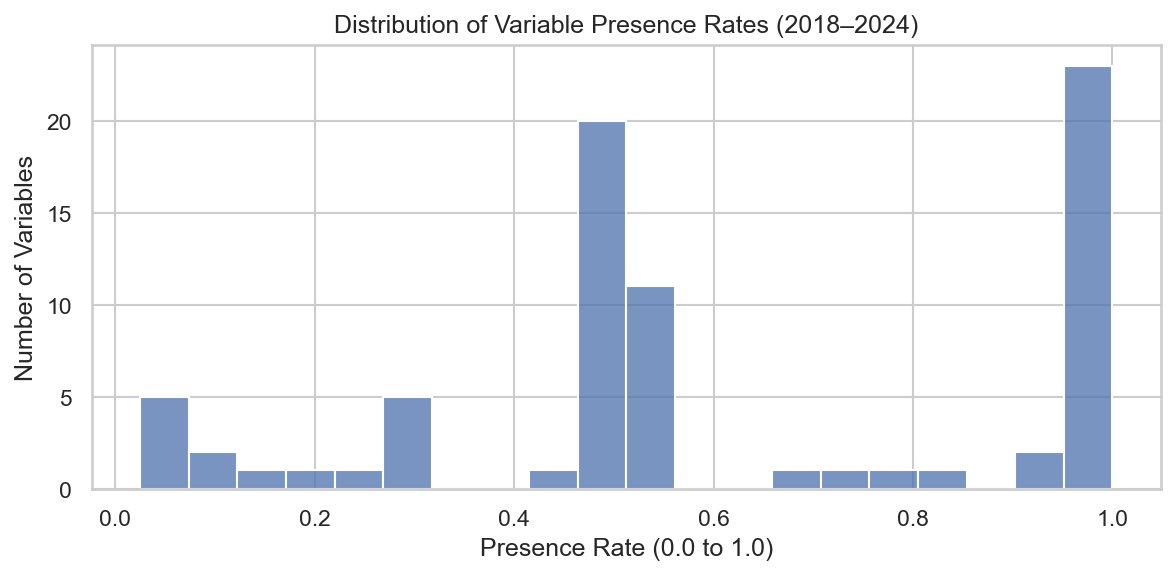

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set global style and resolution
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 150

# --- Plot 1: Distribution of Presence Rates ---
plt.figure(figsize=(8, 4))
sns.histplot(consistency_df["PresenceRate"], bins=20, kde=False, color="#4C71AC")
plt.title("Distribution of Variable Presence Rates (2018–2024)")
plt.xlabel("Presence Rate (0.0 to 1.0)")
plt.ylabel("Number of Variables")
plt.tight_layout()
plt.show()

C:\Users\Faith\AppData\Local\Temp\ipykernel_2860\2132372495.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=consistency_df, x="ConsistencyTag", palette="muted", order=["consistent", "partial", "inconsistent"])


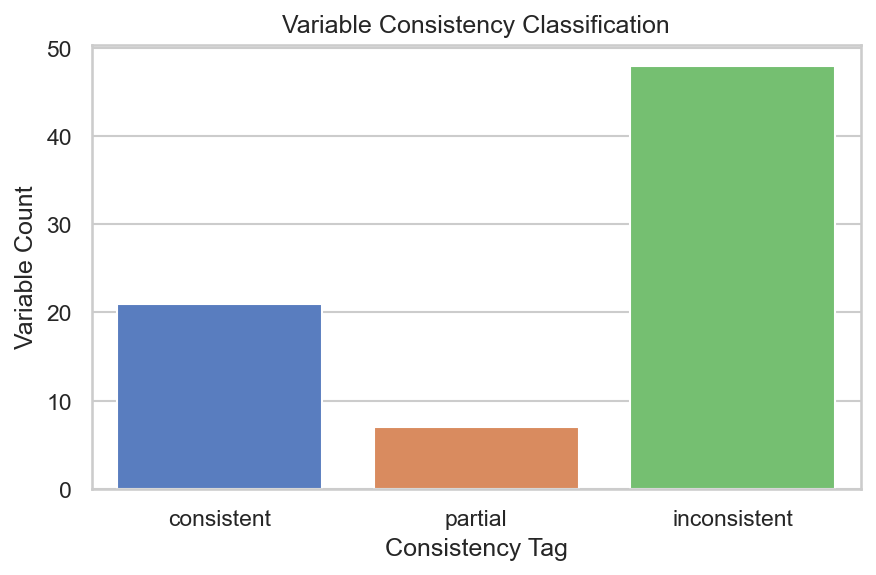

In [6]:
# --- Plot 2: Count of Variables by Consistency Tag ---
plt.figure(figsize=(6, 4))
sns.countplot(data=consistency_df, x="ConsistencyTag", palette="muted", order=["consistent", "partial", "inconsistent"])
plt.title("Variable Consistency Classification")
plt.xlabel("Consistency Tag")
plt.ylabel("Variable Count")
plt.tight_layout()
plt.show()


In [7]:
# --- FINAL CONSISTENCY REPORT (NEAT FORMAT) ---
MAX_VAR_WIDTH = 50  # Adjust this if you want longer or shorter names
print("\n" + "="*85)
print(f"{'VARIABLE':<{MAX_VAR_WIDTH}} | {'MONTHS':<8} | {'RATE':<8} | {'STATUS'}")
print("-" * 85)

total_possible_months = len(all_months)

for _, row in consistency_df.iterrows():
    raw_var_name = str(row['Variable'])
    
    # Truncate long variable names to keep the table neat
    if len(raw_var_name) > MAX_VAR_WIDTH:
        display_name = raw_var_name[:MAX_VAR_WIDTH-3] + "..."
    else:
        display_name = raw_var_name
        
    months_count = len(row['MonthsPresent'])
    presence_rate = (months_count / total_possible_months) * 100
    tag = row['ConsistencyTag'].upper()
    
    # Clean status text
    status_text = tag
    
    print(f"{display_name:<{MAX_VAR_WIDTH}} | {months_count:<8} | {presence_rate:>6.1f}% | {status_text}")

print("="*85)
print(f"Timeline: {all_months[0]} to {all_months[-1]}")
print(f"Total Reference Months: {total_possible_months}")


VARIABLE                                           | MONTHS   | RATE     | STATUS
-------------------------------------------------------------------------------------
Available for Work                                 | 40       |  100.0% | CONSISTENT
C03-Relationship to Household Head                 | 40       |  100.0% | CONSISTENT
C04-Sex                                            | 40       |  100.0% | CONSISTENT
C05-Age as of Last Birthday                        | 40       |  100.0% | CONSISTENT
C06-Marital Status                                 | 40       |  100.0% | CONSISTENT
C07-Highest Grade Completed                        | 40       |  100.0% | CONSISTENT
C101-Line Number                                   | 40       |  100.0% | CONSISTENT
Household Size                                     | 40       |  100.0% | CONSISTENT
Look for Additional Work                           | 40       |  100.0% | CONSISTENT
Looked for Work or Tried to Establish Business ... | 40       |  1

Even if a variable appears in all survey months, it does not automatically mean it is usable for longitudinal analysis. Beyond temporal consistency, it is also necessary to verify whether the category values of each variable remain consistent across time.

To address this, a hybrid audit was performed. For variables that were previously harmonized, category values were extracted directly from the decoded survey data. For other variables, category labels were retrieved from the clean metadata (Sheet 2). 

In [9]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# --- 1. SET PATHS (Aligned with your notebook flow) ---
METADATA_ROOT = BASE_PATH / "NEW Metadata Sheet 2 CSV's"
RENAMED_ROOT = BASE_PATH / "NEW Renamed Fully Decoded Surveys"

# --- 2. DYNAMICALLY GET CONSISTENT VARIABLES ---
try:
    consistent_vars = consistency_df[consistency_df['ConsistencyTag'] == 'consistent']['Variable'].tolist()
    
    # These are variables that were previously cleaned/harmonized in your pipeline
    PROVIDED_HARMONIZED = [
        "Work Indicator", "Available for Work", "Urban-RuralFIES", 
        "Location of Work (Province, Municipality)", "Normal Working Hours per Day", 
        "Want More Hours of Work", "Look for Additional Work", "Other Job Indicator", 
        "Total Hours Worked for all Jobs", "Looked for Work or Tried to Establish Business During the Past Week", 
        "First Time to Look for Work", "Previous Job Indicator", "Previous Occupation", 
        "Kind of Business (Past Quarter)", "Province", "Province Recode"
    ]
    
    # Detect which harmonized vars are actually in your consistent list
    HARMONIZED_VARS = [v for v in PROVIDED_HARMONIZED if v in consistent_vars]
    
    print(f" Total Consistent Variables: {len(consistent_vars)}")
    print(f" Harmonized Variables detected in report: {len(HARMONIZED_VARS)}")
except NameError:
    print("[ERROR] 'consistency_df' not found. Please run Code Block 4 first.")
    consistent_vars = []
    HARMONIZED_VARS = []

def normalize(text):
    """Standardizes text for comparison (lowercase, no extra spaces)."""
    return re.sub(r'\s+', ' ', str(text).strip().lower())

def run_hybrid_label_audit(survey_path, metadata_path, vars_list, harmonized_list):
    # Dictionary to track labels per variable per month
    variable_labels_by_month = {var: {} for var in vars_list}
    year_folders = sorted([d for d in survey_path.iterdir() if d.is_dir()], key=lambda x: x.name)

    print("\n" + "="*85)
    print("           CONSISTENT VARIABLES VALUE CATEGORY CHECK           ")
    print("="*85)

    for year_folder in year_folders:
        year = year_folder.name
        survey_files = {f.stem.split('_')[0].capitalize(): f for f in year_folder.glob("*.csv")}
        
        # Metadata files are organized by Year folders
        meta_year_dir = metadata_path / year
        meta_files = {f.stem.split('_')[1].capitalize(): f for f in meta_year_dir.glob("Sheet2_*.csv")} if meta_year_dir.exists() else {}

        # Sort months using your config MONTH_ORDER
        months = sorted(survey_files.keys(), key=lambda x: cfg["MONTH_ORDER"].get(x, 99))

        for month in months:
            month_year = f"{month} {year}"
            
            # SOURCE A: Harmonized Variables -> Check the actual Survey Data
            if month in survey_files and harmonized_list:
                df_survey = pd.read_csv(survey_files[month], low_memory=False)
                for var in harmonized_list:
                    if var in df_survey.columns:
                        labels = {normalize(s) for s in df_survey[var].dropna().unique().astype(str)}
                        if labels: variable_labels_by_month[var][month_year] = labels

            # SOURCE B: Unique Variables -> Check the Metadata (Sheet 2)
            if month in meta_files:
                df_meta = pd.read_csv(meta_files[month])
                unique_vars = [v for v in vars_list if v not in harmonized_list]
                for var in unique_vars:
                    # Match the variable name in the 'Description' column of Sheet 2
                    subset = df_meta[df_meta['Description'].astype(str).str.strip() == var]
                    if not subset.empty:
                        labels = {normalize(s) for s in subset['Label'].dropna().unique().astype(str)}
                        if labels: variable_labels_by_month[var][month_year] = labels

    # --- RESULTS REPORTING ---
    for var in vars_list:
        per_month = variable_labels_by_month[var]
        source_label = "SURVEY DATA" if var in harmonized_list else "METADATA (SHEET 2)"
        
        if not per_month:
            print(f"\nVARIABLE: {var} ({source_label})")
            print("  [NOTE]: No categories found. Likely a numeric or literal variable.")
            print("-" * 60)
            continue

        print(f"\nVARIABLE: {var} ({source_label})")
        
        # Calculate consistency across all months found
        overall_union = set().union(*per_month.values())
        sorted_months = sorted(per_month.keys(), key=lambda x: (int(x.split()[-1]), cfg["MONTH_ORDER"].get(x.split()[0], 99)))
        
        for month in sorted_months:
            sorted_labels = sorted(list(per_month[month]))
            # Show a snippet of the labels
            label_str = ", ".join(sorted_labels[:8]) + (f" ... (+{len(sorted_labels)-8})" if len(sorted_labels) > 8 else "")
            print(f"  {month:15}: {label_str}")

        # Check if every month has the exact same set of labels
        is_consistent = all(per_month[m] == overall_union for m in sorted_months)
        status_tag = "[SUCCESS]" if is_consistent else "[ALERT]"
        print(f"\n{status_tag} Identical coding scheme across all months?: {'YES' if is_consistent else 'NO'}")
        print("-" * 60)

# --- EXECUTION ---
run_hybrid_label_audit(RENAMED_ROOT, METADATA_ROOT, consistent_vars, HARMONIZED_VARS)

 Total Consistent Variables: 21
 Harmonized Variables detected in report: 9

           CONSISTENT VARIABLES VALUE CATEGORY CHECK           

VARIABLE: Available for Work (SURVEY DATA)
  January 2018   : no, yes
  April 2018     : no, yes
  July 2018      : no, yes
  October 2018   : no, yes
  January 2019   : no, yes
  April 2019     : no, yes
  July 2019      : no, yes
  October 2019   : no, yes
  January 2022   : no, yes
  February 2022  : no, yes
  March 2022     : no, yes
  April 2022     : no, yes
  May 2022       : no, yes
  June 2022      : no, yes
  July 2022      : no, yes
  August 2022    : no, yes
  September 2022 : no, yes
  October 2022   : no, yes
  November 2022  : no, yes
  December 2022  : no, yes
  January 2023   : no, yes
  February 2023  : no, yes
  March 2023     : no, yes
  April 2023     : no, yes
  May 2023       : no, yes
  June 2023      : no, yes
  July 2023      : no, yes
  August 2023    : no, yes
  September 2023 : no, yes
  October 2023   : no, yes
  Nov

The summary generated in the previous step classifies variables into two groups: those with identical category schemes across survey months (“YES”) and those with differences in category labels (“NO”).

All variables flagged as “NO” will still undergo manual inspection to determine whether the detected inconsistencies reflect real changes in the data or are simply differences in metadata descriptions.

In [20]:
# --- EXECUTION WITH CATEGORIZED SUMMARY ---

def run_hybrid_label_audit_with_summary(survey_path, metadata_path, vars_list, harmonized_list):
    variable_labels_by_month = {var: {} for var in vars_list}
    year_folders = sorted([d for d in survey_path.iterdir() if d.is_dir()], key=lambda x: x.name)
    
    # Storage for the final summary
    yes_vars = []
    no_vars = []

    for year_folder in year_folders:
        year = year_folder.name
        survey_files = {f.stem.split('_')[0].capitalize(): f for f in year_folder.glob("*.csv")}
        meta_year_dir = metadata_path / year
        meta_files = {f.stem.split('_')[1].capitalize(): f for f in meta_year_dir.glob("Sheet2_*.csv")} if meta_year_dir.exists() else {}

        months = sorted(survey_files.keys(), key=lambda x: cfg["MONTH_ORDER"].get(x, 99))

        for month in months:
            month_year = f"{month} {year}"
            
            if month in survey_files and harmonized_list:
                df_survey = pd.read_csv(survey_files[month], low_memory=False)
                for var in harmonized_list:
                    if var in df_survey.columns:
                        labels = {normalize(s) for s in df_survey[var].dropna().unique().astype(str)}
                        if labels: variable_labels_by_month[var][month_year] = labels

            if month in meta_files:
                df_meta = pd.read_csv(meta_files[month])
                unique_vars = [v for v in vars_list if v not in harmonized_list]
                for var in unique_vars:
                    subset = df_meta[df_meta['Description'].astype(str).str.strip() == var]
                    if not subset.empty:
                        labels = {normalize(s) for s in subset['Label'].dropna().unique().astype(str)}
                        if labels: variable_labels_by_month[var][month_year] = labels

    # --- CATEGORIZATION LOGIC ---
    for var in vars_list:
        per_month = variable_labels_by_month[var]
        
        if not per_month:
            # Numeric/Literal variables are consistent by nature
            yes_vars.append(var)
            continue

        overall_union = set().union(*per_month.values())
        is_consistent = all(per_month[m] == overall_union for m in per_month.keys())
        
        if is_consistent:
            yes_vars.append(var)
        else:
            no_vars.append(var)

    # --- FINAL CLEAN OUTPUT ---
    print("\n" + "="*85)
    print("      IDENTICAL CODING SCHEME?      ")
    print("="*85)
    
    print(f"\nYES ({len(yes_vars)} variables):")
    for v in sorted(yes_vars):
        print(f" - {v}")

    print(f"\nNO ({len(no_vars)} variables):")
    for v in sorted(no_vars):
        print(f" - {v}")
    
    print("\n" + "="*85)

# Run the audit
run_hybrid_label_audit_with_summary(RENAMED_ROOT, METADATA_ROOT, consistent_vars, HARMONIZED_VARS)


      IDENTICAL CODING SCHEME?      

YES (12 variables):
 - Available for Work
 - C04-Sex
 - C101-Line Number
 - Look for Additional Work
 - Looked for Work or Tried to Establish Business During the Past Week
 - Normal Working Hours per Day
 - Other Job Indicator
 - Previous Job Indicator
 - Psu Number
 - Replicate
 - Want More Hours of Work
 - Work Indicator

NO (9 variables):
 - C03-Relationship to Household Head
 - C05-Age as of Last Birthday
 - C06-Marital Status
 - C07-Highest Grade Completed
 - Household Size
 - New Employment Criteria (jul 05, 2005)
 - Survey Month
 - Survey Year
 - Total Hours Worked for all Jobs



#### **Manual Inspection Result**
The variables flagged as inconsistent fall into two types:

##### **1. Variables That Do Not Require Harmonization Despite Being Flagged**

Some variables were marked as inconsistent by the automated audit. However, manual inspection shows that their underlying data are stable across survey months. The detected differences are due to changes in metadata descriptions rather than actual changes in the recorded values.

The following variables were therefore classified as conceptually consistent and do not require harmonization:

**Numeric Variables (Actual Data Remains Stable)**

- **C05 – Age as of Last Birthday**

This variable contains numerical age values. Although metadata labels may differ across survey months, the recorded values consistently represent age in years.

- **Household Size**

This variable records the number of household members as integers. Differences in metadata wording do not affect the meaning or structure of the data.

- **Total Hours Worked for All Jobs**

This variable contains numerical values representing total working hours. The underlying data format remains consistent across all survey months.

**Structural Variables (Temporal Identifiers)**

- **Survey Month and Survey Year**

These variable serves as a time identifier. Although metadata descriptions vary, the month and year values remain consistent and interpretable across all survey periods. Metadata differences do not affect its meaning or analytical use.

##### **2. Variables That Require Further Harmonization or Evaluation**

Other variables were flagged because their category labels genuinely changed across survey months. These include:

- **C03-Relationship to Household Head**
- **C06-Marital Status**
- **C07-Highest Grade Completed**

For these variables, the differences reflect real shifts in category structures rather than metadata noise. They will be examined in detail in the next step to determine whether harmonization is feasible or whether exclusion is more appropriate.

---
### Assessment of Unstable Variables

A focused category label check was conducted for the following variables:
- C03-Relationship to Household Head
- C06-Marital Status
- C07-Highest Grade Completed

This tracks how category labels evolve over time and identifies which labels appear or disappear across survey months.


In [10]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# --- 1. SET PATHS ---
METADATA_ROOT = BASE_PATH / "NEW Metadata Sheet 2 CSV's"

# Variables to audit for internal categorical consistency
UNSTABLE_VARS = [
    "C03-Relationship to Household Head",
    "C06-Marital Status",
    "C07-Highest Grade Completed"
]

def normalize(text):
    """Standardizes text for comparison (lowercase, no extra spaces)."""
    return re.sub(r'\s+', ' ', str(text).strip().lower())

def run_unstable_category_audit(metadata_path, vars_list):
    # Dictionary to store labels: {variable: {month_year: set_of_labels}}
    variable_labels_by_month = {var: {} for var in vars_list}
    
    # Identify Year Folders
    year_folders = sorted([d for d in metadata_path.iterdir() if d.is_dir()], key=lambda x: x.name)

    print("\n" + "="*85)
    print("      UNSTABLE VARIABLE CATEGORY CHECK: LONGITUDINAL AUDIT      ")
    print("="*85)

    for year_folder in year_folders:
        year = year_folder.name
        # Sort Sheet2 CSV files chronologically based on your MONTH_ORDER config
        files = sorted(
            year_folder.glob("Sheet2_*.csv"),
            key=lambda x: cfg["MONTH_ORDER"].get(x.stem.split('_')[1].capitalize(), 99)
        )

        for file_path in files:
            parts = file_path.stem.split('_')
            month_name = parts[1].capitalize() if len(parts) > 1 else "Unknown"
            month_year = f"{month_name} {year}"
            
            try:
                df_meta = pd.read_csv(file_path)
                
                for var in vars_list:
                    # Match 'Description' with the unstable variable name
                    subset = df_meta[df_meta['Description'].astype(str).str.strip() == var]
                    
                    if not subset.empty:
                        # Extract and normalize labels
                        labels = {normalize(s) for s in subset['Label'].dropna().unique().astype(str)}
                        if labels:
                            variable_labels_by_month[var][month_year] = labels
            except Exception:
                continue 

    # --- DETAILED PRINTING ---
    for var in vars_list:
        per_month = variable_labels_by_month[var]
        if not per_month: 
            print(f"\nVARIABLE: {var}")
            print(" [ALERT] No metadata entries found.")
            print("-" * 60)
            continue

        print(f"\nVARIABLE: {var}")
        
        # Determine the master list of all labels ever seen for this variable
        overall_union = set()
        for labels in per_month.values():
            overall_union.update(labels)
        
        # Sort months chronologically for the output
        sorted_months = sorted(per_month.keys(), 
                               key=lambda x: (int(x.split()[-1]), cfg["MONTH_ORDER"].get(x.split()[0], 99)))
        
        for month in sorted_months:
            labels = per_month[month]
            sorted_labels = sorted(list(labels))
            
            # Print ALL labels found in this survey month for manual inspection
            label_str = ", ".join(sorted_labels)
            print(f"  {month:15}: {label_str if label_str else '(empty)'}")

        # --- COMPARISON SUMMARY ---
        is_consistent = all(per_month[m] == overall_union for m in sorted_months)
        status_tag = "[SUCCESS]" if is_consistent else "[ALERT]"
        print(f"\n{status_tag} Identical coding scheme across all months?: {'YES' if is_consistent else 'NO'}")
        
        if not is_consistent:
            # Highlight labels that are NOT present in every single month
            print("Detected Temporal Inconsistencies (Labels missing in some months):")
            for month in sorted_months:
                missing = overall_union - per_month[month]
                if missing:
                    print(f"  - Missing in {month}: {sorted(list(missing))}")
        print("-" * 60)

# --- EXECUTION ---
run_unstable_category_audit(METADATA_ROOT, UNSTABLE_VARS)


      UNSTABLE VARIABLE CATEGORY CHECK: LONGITUDINAL AUDIT      

VARIABLE: C03-Relationship to Household Head
  January 2018   : boarder, brothers/sisters, domestic helper, father/mother, grandchildren, head, non_relative, other relative, son/daughter, son/daughter_law, wife/spouse
  April 2018     : boarder, brothers/sisters, domestic helper, father/mother, grandchildren, head, non_relative, other relative, son/daughter, son/daughter_law, wife/spouse
  July 2018      : boarder, brothers/sisters, domestic helper, father/mother, grandchildren, head, non_relative, other relative, son/daughter, son/daughter_law, wife/spouse
  October 2018   : boarder, brothers/sisters, domestic helper, father/mother, grandchildren, head, non_relative, other relative, son/daughter, son/daughter_law, wife/spouse
  January 2019   : boarder, brothers/sisters, domestic helper, father/mother, grandchildren, head, non_relative, other relative, son/daughter, son/daughter_law, wife/spouse
  April 2019     : boar

##### Checking Undetected Survey Months for C07 – Highest Grade Completed

During the previous step where we audited category values for the three unstable variables, it was observed that not all survey months were successfully detected for the `C07 – Highest Grade Completed` variable.

This could be due to inconsistencies in the metadata, such as variable name changes or incomplete category/value entries in some months. **The metadata of the survey months that did not account for this variable will be identified and manually inspected to confirm the state of the variable and assess its harmonizability.**

In [22]:
import pandas as pd
from pathlib import Path

# --- 1. SET PATHS ---
METADATA_ROOT = BASE_PATH / "NEW Metadata Sheet 2 CSV's"

# Exact names to audit (Matching your primary audit script)
UNSTABLE_VARS = [
    "C03-Relationship to Household Head",
    "C06-Marital Status",
    "C07-Highest Grade Completed"
]

def identify_undetected_unstable_months(metadata_path, vars_list):
    # Dictionary to track presence: {variable: [list of undetected month_years]}
    undetected_tracker = {var: [] for var in vars_list}
    
    # Identify Year Folders
    year_folders = sorted([d for d in metadata_path.iterdir() if d.is_dir()], key=lambda x: x.name)

    for year_folder in year_folders:
        year = year_folder.name
        # Sort Sheet2 CSV files chronologically
        files = sorted(
            year_folder.glob("Sheet2_*.csv"),
            key=lambda x: cfg["MONTH_ORDER"].get(x.stem.split('_')[1].capitalize(), 99)
        )

        for file_path in files:
            month = file_path.stem.split('_')[1].capitalize()
            month_year = f"{month} {year}"
            
            try:
                df_meta = pd.read_csv(file_path)
                # Clean descriptions for exact matching
                descriptions = df_meta['Description'].astype(str).str.strip().tolist()
                
                for var in vars_list:
                    # EXACT MATCH check
                    if var not in descriptions:
                        undetected_tracker[var].append((month_year, file_path.name))
                        
            except Exception:
                # If a file is unreadable, assume all vars in that month are undetected
                for var in vars_list:
                    undetected_tracker[var].append((month_year, f"{file_path.name} (Error reading)"))
                continue 

    # --- SIMPLIFIED REPORTING ---
    print("\n" + "="*85)
    print("      UNDETECTED MONTHS REPORT (EXACT NAME MATCHING)      ")
    print("="*85)
    
    for var in vars_list:
        undetected_list = undetected_tracker[var]
        print(f"\nVARIABLE: {var}")
        
        if not undetected_list:
            print("    [SUCCESS] Found in all survey months.")
        else:
            print(f"    [ALERT] Total Undetected: {len(undetected_list)}")
            print("   " + "-" * 40)
            for month_year, filename in undetected_list:
                print(f"   {month_year:15} | File: {filename}")
    
    print("\n" + "="*85)

# --- EXECUTION ---
identify_undetected_unstable_months(METADATA_ROOT, UNSTABLE_VARS)


      UNDETECTED MONTHS REPORT (EXACT NAME MATCHING)      

VARIABLE: C03-Relationship to Household Head
    [SUCCESS] Found in all survey months.

VARIABLE: C06-Marital Status
    [SUCCESS] Found in all survey months.

VARIABLE: C07-Highest Grade Completed
    [ALERT] Total Undetected: 21
   ----------------------------------------
   July 2018       | File: Sheet2_July_2018.csv
   February 2022   | File: Sheet2_February_2022.csv
   March 2022      | File: Sheet2_March_2022.csv
   May 2022        | File: Sheet2_May_2022.csv
   June 2022       | File: Sheet2_June_2022.csv
   August 2022     | File: Sheet2_August_2022.csv
   September 2022  | File: Sheet2_September_2022.csv
   November 2022   | File: Sheet2_November_2022.csv
   December 2022   | File: Sheet2_December_2022.csv
   March 2023      | File: Sheet2_March_2023.csv
   May 2023        | File: Sheet2_May_2023.csv
   June 2023       | File: Sheet2_June_2023.csv
   August 2023     | File: Sheet2_August_2023.csv
   September 2023  

##### **Implications of `C07-Highest Grade Completed`**

Upon manual inspection of the undetected months analysis, it is confirmed that:

- The variable shows extreme variation in categories across survey months. Early surveys include detailed educational distinctions (SPED levels, year-specific grades, undergraduate/graduate), while later surveys are simplified.
- Metadata inconsistencies like name changes further complicate alignment.
- Several categories in earlier surveys **have no corresponding category** in later surveys, making harmonization unreliable.

**Decision:**
Given these issues, C07 – Highest Grade Completed cannot be reliably harmonized. Any attempt to include it in analysis would lead to artificial merging of non-comparable categories, potentially introducing bias.

**Action:**
C07 – Highest Grade Completed will be excluded from the analysis. The decision reflects both the **category conflicts and metadata inconsistencies identified**.

---
#### The "Labor Force" Metadata Anomaly

During the category check, the variable `New Employment Criteria (Jul 05, 2005)` was flagged due to an extra category labeled **“Labor Force”** appearing in the October 2018 metadata. However, this label essentially **acts as a broad header or grouping** in the documentation, not as a concrete category for respondents.

To verify this, a direct scan of all decoded survey files will be conducted to identify the actual values present in the dataset.

In [21]:
import pandas as pd
from pathlib import Path

# --- CONFIGURATION ---
# Ensure RENAMED_ROOT points to your "NEW Renamed Fully Decoded Surveys" folder
TARGET_VAR = "New Employment Criteria (jul 05, 2005)"

def audit_employment_values(data_path, variable_name):
    print("\n" + "="*95)
    print(f"      VALUE AUDIT: {variable_name}      ")
    print("="*95)
    print(f"{'Month & Year':<20} | {'Unique Values Found in Decoded Data'}")
    print("-" * 95)

    year_folders = sorted([d for d in data_path.iterdir() if d.is_dir()])
    all_found_values = set()

    for year_folder in year_folders:
        year = year_folder.name
        # Sort files by month using your config order if needed, 
        # but a simple glob works for a total value check
        for file_path in sorted(year_folder.glob("*.csv")):
            month = file_path.name.split('_')[0].capitalize()
            
            try:
                # Load only the specific column to save memory
                df = pd.read_csv(file_path, usecols=[variable_name])
                
                # Get unique values, remove NaNs, and sort them
                uniques = sorted([str(val) for val in df[variable_name].dropna().unique()])
                all_found_values.update(uniques)
                
                # Print result for this specific month
                values_str = ", ".join(uniques)
                print(f"{month + ' ' + year:<20} | {values_str}")
                
            except Exception as e:
                print(f"{month + ' ' + year:<20} | Error: {e}")

    print("-" * 95)
    print(f"OVERALL UNIQUE VALUES ACROSS ALL MONTHS:")
    print(f"-> {sorted(list(all_found_values))}")
    print("="*95)
    
    # Verification Logic
    if "labor force" in [v.lower() for v in all_found_values]:
        print(" [ALERT] 'Labor Force' was detected in the data.")
    else:
        print(" [CONFIRMED] 'Labor Force' is NOT present in the data. The decoder successfully filtered it.")

# --- EXECUTION ---
audit_employment_values(RENAMED_ROOT, TARGET_VAR)


      VALUE AUDIT: New Employment Criteria (jul 05, 2005)      
Month & Year         | Unique Values Found in Decoded Data
-----------------------------------------------------------------------------------------------
April 2018           | employed, not in the labor force, unemployed
January 2018         | employed, not in the labor force, unemployed
July 2018            | employed, not in the labor force, unemployed
October 2018         | employed, not in the labor force, unemployed
April 2019           | employed, not in the labor force, unemployed
January 2019         | employed, not in the labor force, unemployed
July 2019            | employed, not in the labor force, unemployed
October 2019         | employed, not in the labor force, unemployed
April 2022           | employed, not in the labor force, unemployed
August 2022          | employed, not in the labor force, unemployed
December 2022        | employed, not in the labor force, unemployed
February 2022        | employed,

Because the decoder ignores the broad “Labor Force” label and consistently maps respondents to these specific categories, all decoded survey datasets remain uniform across survey months, even though the metadata differs. This review of all decoded survey files confirms that the “Labor Force” label never appears in the actual data columns, considering the variable consistent across all survey months from 2018 to 2024.

### Variable Stability Considerations and Researcher Decisions

An automated check was performed to see whether variable categories were consistent across survey months. Some variables were flagged as "inconsistent." However, after manual inspection, it became clear that many of these issues were caused by changes in documentation or labels, not changes in the actual data values.

To ensure that only reliable variables are used in the analysis, each variable was evaluated based on whether it is truly consistent and suitable for harmonization.

---

#### 1. Numeric and Structural Variables (No Harmonization Needed)

The following variables contain numbers or fixed identifiers. Even though their descriptions in the metadata sometimes changed, the actual data values remained the same. Therefore, these variables are considered stable and do not require harmonization.

- **C05 - Age as of Last Birthday**  
  The variable consistently contains numerical age values across all survey years.

- **Household Size**  
  The variable consistently records the number of household members.

- **Total Hours Worked for All Jobs**  
  The variable consistently records the total number of hours worked.

- **Survey Month and Survey Year**  
  These variables identify when the survey was conducted. Differences in metadata labels do not affect their meaning or use in analysis.

The automated system flagged these variables as inconsistent, but manual checking confirmed that they are stable. No harmonization is required.

---

#### 2. Decoder-Resolved Metadata Difference: The “Labor Force” Category

- **New Employment Criteria (Jul 05, 2005)**  

In the October 2018 metadata, an additional category labeled “Labor Force” is listed. However, this label does not represent an actual response category in the survey data. Instead, it functions as a broader grouping in the documentation.

The decoding process is designed to extract only the concrete employment statuses (e.g., Employed, Unemployed, Not in the Labor Force). As a result, the decoder does not treat “Labor Force” as a valid data value and consistently assigns respondents to the specific status categories.

Because of this, all decoded survey datasets contain the same set of employment status categories across survey months, despite the metadata difference in October 2018.

**Verification:** A review of all decoded survey files confirms that the “Labor Force” label never appears in the data columns. Therefore, this variable is considered structurally consistent across the 2018-2024 period.

---

#### 3. True Categorical Differences (Harmonization Needed)

The following variables show real differences in category labels across survey months. Because their categories changed over time, they must be harmonized before they can be used in the analysis.

- **C03 – Relationship to Household Head**  
  Category labels differ across survey months, so they need to be grouped into a set of standard relationship categories.

- **C06 – Marital Status**  
  Some labels changed over time, so a clear and consistent category mapping is required.

To ensure comparability across all survey months, detailed categories are grouped into broader categories that are consistently present throughout the dataset. This approach preserves the core meaning of each variable while ensuring that the same category structure is used across time.

---

#### 4. Variable That Cannot Be Reliably Harmonized (Planned Exclusion)

- **C07 – Highest Grade Completed**

This variable shows conflicts in category structure across survey years. In earlier surveys, education levels are recorded using highly detailed categories (e.g., Preschool, SPED levels, specific year levels, undergraduate and graduate distinctions). In later surveys, these detailed categories no longer exist and are replaced by broader and simplified groupings.

As a result, several categories that appear in earlier surveys have no equivalent categories in later surveys. Because there is no stable set of categories that exists across all survey months, these differences cannot be aligned without either oversimplifying the data or making subjective assumptions about category equivalence.

Since the category systems do not overlap in a consistent way, any attempt to harmonize them would require artificial merging of categories that are not conceptually comparable across survey years.

**Decision:** Although C07 is present in all survey months, its category structure is not compatible across time. To avoid forced mappings, loss of meaning, and potential bias, C07 – Highest Grade Completed will be excluded from the analysis.

---

#### Summary of Findings

Based on the assessment:

- Two categorical variables (C03 and C06) can be harmonized and will be included in the analysis.
- One categorical variable (C07) will be excluded because it cannot be harmonized reliably.
- All other flagged variables are actually stable. Their inconsistencies are only due to metadata label changes, not changes in the data itself.

This process ensures that only consistent and comparable variables are used in Factor Analysis and the subsequent analysis, improving the reliability of results across survey months.


---
### Pre-Harmonization Stage: Purpose and Overview

Before performing harmonization of categorical variables across survey months, it is important to ensure that:

1. **Structural variables are consistent across survey months**, such as survey month and survey year. Every survey file must correctly identify the associated month and year in a standardized format. Any inconsistencies here can affect longitudinal alignment and temporal analysis.

2. **All categorical values are properly decoded**, so that no residual or unexpected raw codes remain that could interfere with analysis or imputation.

#### Auditing Temporal Constants (Survey Month & Year)

This code was developed following a manual inspection of the metadata. Some survey months lacked specific metadata entries for the "Survey Year" variable, or displayed inconsistencies in how months were categorized. Standardizing these temporal constants is essential for the accurate chronological alignment of the 40 months of survey data.

In [23]:
import pandas as pd
from pathlib import Path

# --- CONFIGURATION ---
# Target variables for structural proof
TARGET_VARS = ["Survey Month", "Survey Year"]

def audit_temporal_constants(data_path, variables):
    print("\n" + "="*95)
    print(f"      VALUE AUDIT: TEMPORAL CONSTANTS (MONTH & YEAR)      ")
    print("="*95)
    print(f"{'File Period':<20} | {'Found Month Values':<25} | {'Found Year Values'}")
    print("-" * 95)

    # Iterate through year folders (2018, 2019, etc.)
    year_folders = sorted([d for d in data_path.iterdir() if d.is_dir()])

    for year_folder in year_folders:
        # Iterate through month files in chronological order
        for file_path in sorted(year_folder.glob("*.csv")):
            file_label = file_path.stem  # e.g., "January_2018_Renamed"
            
            try:
                # Load only the necessary columns
                df = pd.read_csv(file_path, usecols=variables)
                
                # Extract unique values for both columns
                month_uniques = sorted([str(val) for val in df[variables[0]].dropna().unique()])
                year_uniques = sorted([str(val) for val in df[variables[1]].dropna().unique()])
                
                # Format for printing
                month_str = ", ".join(month_uniques)
                year_str = ", ".join(year_uniques)
                
                print(f"{file_label[:20]:<20} | {month_str:<25} | {year_str}")
                
            except Exception as e:
                print(f"{file_label[:20]:<20} | ERROR: {e}")

    print("="*95)
    print(" [VERIFICATION] If each row shows exactly one month and one year matching the filename,")
    print("                the temporal constants are 100% consistent across the dataset.")
    print("="*95)

# --- EXECUTION ---
# Ensure RENAMED_ROOT is defined in your notebook
audit_temporal_constants(RENAMED_ROOT, TARGET_VARS)


      VALUE AUDIT: TEMPORAL CONSTANTS (MONTH & YEAR)      
File Period          | Found Month Values        | Found Year Values
-----------------------------------------------------------------------------------------------
APRIL_2018           | april                     | 18
JANUARY_2018         | january                   | 2018
JULY_2018            | july                      | 18
OCTOBER_2018         | october                   | 18
APRIL_2019           | april                     | 19
JANUARY_2019         | january                   | 19
JULY_2019            | july                      | 2019
OCTOBER_2019         | october                   | 2019
APRIL_2022           | april                     | 2022
AUGUST_2022          | august                    | 2022
DECEMBER_2022        | december                  | 2022
FEBRUARY_2022        | 2                         | 2022
JANUARY_2022         | january                   | 2022
JULY_2022            | july                      | 2022
J

The temporal audit reveals several formatting inconsistencies across the dataset that require standardization prior to longitudinal analysis. While the majority of the survey months are correctly identified, there are specific instances of data entry variation, such as two-digit year formats in 2018 and 2019 (e.g., "18" and "19"), numeric month representations for February and March 2022 (e.g., "2" and "3"), and a literal text placeholder ("survey year") in the June 2024 file. **These discrepancies requires correction to ensure all temporal constants are converted to a uniform 4-digit year and full-string month format.**

#### Decoding Residual Detection

This second audit checks for undecoded or residual categorical values. While most variables were successfully processed by the automated decoder, **variables in some survey months may still contain numeric codes without corresponding labels in the associated metadata files**. This is important for variables that will later undergo imputation or harmonization, as residual values can introduce errors or bias.

In [29]:
import pandas as pd
import re
import numpy as np
from pathlib import Path

# --- CONFIGURATION ---
INPUT_DIR = BASE_PATH / "NEW Renamed Fully Decoded Surveys"

# Variables EXCLUDED from the audit because they are numeric, 
# temporal constants, or planned for exclusion (C07).
NUMERIC_EXCEPTIONS = [
    "C101-Line Number",
    "Normal Working Hours per Day",
    "Psu Number",
    "Replicate",
    "Want More Hours of Work",
    "C05-Age as of Last Birthday",
    "Household Size",
    "Survey Month",
    "Survey Year",
    "Total Hours Worked for all Jobs",
    "C07-Highest Grade Completed"
]

def run_residual_audit(input_path, variables_to_audit):
    residual_report = {var: {} for var in variables_to_audit}
    fully_decoded_vars = [] # Track variables with NO residuals
    
    year_folders = sorted([d for d in input_path.iterdir() if d.is_dir()])
    
    print("\n" + "="*95)
    print("      PRE-HARMONIZATION RESIDUAL AUDIT: DETECTING UNMAPPED CODES      ")
    print("="*95)

    for year_folder in year_folders:
        year = year_folder.name
        for file_path in sorted(year_folder.glob("*.csv")):
            month_name = file_path.name.split('_')[0].capitalize()
            month_year = f"{month_name} {year}"
            
            try:
                df_cols = pd.read_csv(file_path, nrows=0).columns.tolist()
                load_cols = [v for v in variables_to_audit if v in df_cols]
                df = pd.read_csv(file_path, usecols=load_cols, low_memory=False)
                
                for var in load_cols:
                    if var in NUMERIC_EXCEPTIONS:
                        continue
                        
                    actual_values = df[var].dropna().unique()
                    
                    for val in actual_values:
                        if isinstance(val, (float, np.float64)) and val.is_integer():
                            val_str = str(int(val))
                        else:
                            val_str = str(val).strip()
                        
                        # LOGIC: Check for raw digits (residuals)
                        if re.match(r'^\d+$', val_str):
                            if val_str not in residual_report[var]:
                                residual_report[var][val_str] = []
                            if month_year not in residual_report[var][val_str]:
                                residual_report[var][val_str].append(month_year)
                                
            except Exception:
                continue

    # --- UPDATED REPORTING ---
    found_any = False
    
    # 1. Print variables that FAILED (have residuals)
    for var in sorted(variables_to_audit):
        if var in NUMERIC_EXCEPTIONS: continue
        
        residuals = residual_report.get(var, {})
        if residuals:
            found_any = True
            print(f"\n VARIABLE: {var} [FLAGGED]")
            print(f"    {'Unmapped Value':20} | {'Appears In Survey Months'}")
            print(f"    {'-'*19} | {'-'*30}")
            
            sorted_keys = sorted(residuals.keys(), key=lambda x: int(x) if x.isdigit() else 0)
            for val in sorted_keys:
                print(f"    {val:20} | {', '.join(residuals[val])}")
        else:
            # 2. Collect variables that PASSED
            fully_decoded_vars.append(var)

    print("\n" + "-"*95)
    print("      DECODING INTEGRITY SUMMARY      ")
    print("-" * 95)
    
    if fully_decoded_vars:
        print("\n[SUCCESS] The following categorical variables are 100% decoded (No Residuals):")
        for v in sorted(fully_decoded_vars):
            print(f"  - {v}")
    
    if not found_any:
        print("\nSTATUS: All audited categorical variables are clean.")
    else:
        print(f"\nSTATUS: {len(residual_report) - len(fully_decoded_vars) - len(NUMERIC_EXCEPTIONS)} variable(s) require manual mapping for residuals.")
    
    print("\n" + "="*95)

# --- EXECUTION ---
all_consistent_vars = [
    "Available for Work", "C04-Sex", "C101-Line Number", "Look for Additional Work",
    "Looked for Work or Tried to Establish Business During the Past Week", 
    "Normal Working Hours per Day", "Other Job Indicator", "Previous Job Indicator", 
    "Psu Number", "Replicate", "Want More Hours of Work", "Work Indicator",
    "C03-Relationship to Household Head", "C05-Age as of Last Birthday", 
    "C06-Marital Status", "C07-Highest Grade Completed", "Household Size", 
    "New Employment Criteria (jul 05, 2005)", "Survey Month", "Survey Year", 
    "Total Hours Worked for all Jobs"
]

run_residual_audit(INPUT_DIR, all_consistent_vars)


      PRE-HARMONIZATION RESIDUAL AUDIT: DETECTING UNMAPPED CODES      

 VARIABLE: C03-Relationship to Household Head [FLAGGED]
    Unmapped Value       | Appears In Survey Months
    ------------------- | ------------------------------
    12                   | February 2024
    15                   | February 2024
    16                   | February 2024
    23                   | February 2024
    24                   | February 2024
    25                   | February 2024
    26                   | February 2024

 VARIABLE: C06-Marital Status [FLAGGED]
    Unmapped Value       | Appears In Survey Months
    ------------------- | ------------------------------
    7                    | February 2024
    8                    | February 2024

-----------------------------------------------------------------------------------------------
      DECODING INTEGRITY SUMMARY      
-----------------------------------------------------------------------------------------------

[SUCCESS] 

The residual audit confirms that while the majority of categorical variables are fully decoded, two specific variables, `C03-Relationship to Household Head` and and `C06-Marital Status`, contain unmapped numeric codes isolated exclusively within the February 2024 survey month. These residuals, such as codes 12, 15, and 26 for relationship status and 7 and 8 for marital status, indicate instances where the decoding script could not find corresponding text labels in that month's specific metadata. **These unmapped values will be set to "unknown" during the harmonization phase** to maintain dataset consistency and prevent invalid numeric entries from affecting the subsequent analysis.

### Harmonization Stage: Standardizing Temporal and Categorical Data

Following the identification of structural and semantic inconsistencies in the previous audit phases, this stage executes the actual **Harmonization Proper**. The harmonization process focuses on two primary corrective actions:

1. **Temporal Standardization:** The goal of Temporal Standardization is to ensure that the time markers (Year and Month) follow a single, identical rule across the entire 40-month dataset. This includes converting two-digit year formats (e.g., "18") to four-digit formats ("2018"), resolving numeric month codes (e.g., "2" to "February"), and correcting literal placeholders found in specific survey months.

2. **Categorical Mapping:** Based on the audit results, the category labels for `C03-Relationship to Household Head` and `C06-Marital Status` can be harmonized. Different variations of the same category like “01 - head” and “head” will be grouped into a single, consistent label. Manual inspection was done to make sure that these changes keep the original meaning of the survey responses across all survey months.

3. **Handling Unmapped Values:** To maintain data integrity, any numeric residuals identified in the prior audit (such as codes 12, 15, or 26 in February 2024) that lack a direct definition in the metadata will be reclassified as "unknown". This ensures that the dataset contains only valid categorical strings, which is essential for the accuracy of the subsequent Imputation and FMI reporting phases.

In [30]:
import pandas as pd
from pathlib import Path

# --- CONFIGURATION ---
INPUT_DIR = BASE_PATH / "NEW Renamed Fully Decoded Surveys"
OUTPUT_DIR = BASE_PATH / "FINAL Consistent Surveys"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# --- MASTER HARMONIZATION DICTIONARY ---
HARMONIZATION_MAP = {
    "C03-Relationship to Household Head": {
        "head": "head", "01 - head": "head",
        "wife/spouse": "spouse", "02 - spouse": "spouse",
        "son/daughter": "child", "03 - son": "child", "04 - daughter": "child", 
        "05 - stepson": "child", "06 - stepdaughter": "child",
        "father/mother": "parent", "11 - father": "parent", "12 - mother": "parent",
        "brothers/sisters": "sibling", "15 - brother": "sibling", "16 - sister": "sibling",
        "grandchildren": "grandchild", "09 - grandson": "grandchild", "10 - granddaughter": "grandchild",
        "son/daughter_law": "in-law relative", "07 - son-in-law": "in-law relative", 
        "08 - daughter-in-law": "in-law relative", "13 - father-in-law": "in-law relative", 
        "14 - mother-in-law": "in-law relative", "17 - brother-in-law": "in-law relative", 
        "18 - sister-in-law": "in-law relative",
        "other relative": "other relative", "19 - uncle": "other relative", "20 - aunt": "other relative", 
        "21 - nephew": "other relative", "22 - niece": "other relative", "23 - other relative, specify": "other relative",
        "boarder": "boarder", "24 - boarder": "boarder",
        "domestic helper": "domestic helper", "25 - domestic helper": "domestic helper",
        "non_relative": "non-relative", "26 - nonrelative, specify": "non-relative"
    },
    "C06-Marital Status": {
        "annulled": "annulled", "07 - annulled": "annulled",
        "divorce/separate": "divorced/separated", "05 - divorced": "divorced/separated", "06 - separated": "divorced/separated",
        "married": "married or common-law/live-in", "02 - married": "married or common-law/live-in", 
        "03 - common-law/live-in": "married or common-law/live-in",
        "single": "single", "01 - single/never married": "single",
        "widowed": "widowed", "04 - widowed": "widowed",
        "unknown": "unknown", "08 - not reported": "unknown"
    }
}

def standardize_temporal_data(df, filename):
    """Fixes inconsistencies found in Result 1: 2-digit years and numeric months."""
    # 1. Fix Survey Year
    if "Survey Year" in df.columns:
        # Convert to string to handle 'survey year' text or floats
        df["Survey Year"] = df["Survey Year"].astype(str).str.strip().str.lower()
        
        # Mapping for 2-digit codes and the June 2024 placeholder
        year_recode = {"18": "2018", "19": "2019", "survey year": "2024"}
        df["Survey Year"] = df["Survey Year"].replace(year_recode)
        
        # Ensure it's a 4-digit numeric string for everything else
        df["Survey Year"] = df["Survey Year"].apply(lambda x: f"20{x}" if len(x) == 2 else x)

    # 2. Fix Survey Month
    if "Survey Month" in df.columns:
        df["Survey Month"] = df["Survey Month"].astype(str).str.strip().str.lower()
        
        # Mapping for numeric months found in 2022
        month_recode = {"2": "february", "3": "march"}
        df["Survey Month"] = df["Survey Month"].replace(month_recode)
    
    return df

def apply_harmonization(base_input, base_output):
    year_folders = sorted([d for d in base_input.iterdir() if d.is_dir()])

    for year_folder in year_folders:
        year = year_folder.name
        out_year_path = base_output / year
        out_year_path.mkdir(exist_ok=True)

        for file_path in year_folder.glob("*.csv"):
            print(f" Harmonizing: {year}/{file_path.name}")
            df = pd.read_csv(file_path, low_memory=False)

            # --- STEP 1: FIX TEMPORAL DATA (Result 1) ---
            df = standardize_temporal_data(df, file_path.name)

            # --- STEP 2: HARMONIZE CATEGORIES (Result 2) ---
            for var, mapping in HARMONIZATION_MAP.items():
                if var in df.columns:
                    # Clean the data: remove decimals (12.0 -> 12), strip, and lowercase
                    df[var] = df[var].astype(str).str.strip().str.lower().str.replace(r'\.0$', '', regex=True)
                    
                    # Map values. Any value not in HARMONIZATION_MAP (like 12, 15, 7, 8) 
                    # becomes 'unknown' per your request.
                    df[var] = df[var].map(lambda x: mapping.get(x, "unknown"))
            
            # Save the final product
            df.to_csv(out_year_path / file_path.name, index=False)

# --- EXECUTION ---
apply_harmonization(INPUT_DIR, OUTPUT_DIR)
print("\n" + "="*85)
print("[SUCCESS] PRE-HARMONIZATION FIXES COMPLETE")
print("1. Temporal Data: Corrected 2-digit years and numeric months.")
print("2. June 2024: Fixed 'survey year' text placeholder to '2024'.")
print("3. C03 & C06: Harmonized labels and forced unmapped residuals to 'unknown'.")
print("="*85)

 Harmonizing: 2018/APRIL_2018.CSV
 Harmonizing: 2018/JANUARY_2018.CSV
 Harmonizing: 2018/JULY_2018.CSV
 Harmonizing: 2018/OCTOBER_2018.CSV
 Harmonizing: 2019/JULY_2019.CSV
 Harmonizing: 2019/APRIL_2019.CSV
 Harmonizing: 2019/JANUARY_2019.CSV
 Harmonizing: 2019/OCTOBER_2019.CSV
 Harmonizing: 2022/NOVEMBER_2022.CSV
 Harmonizing: 2022/FEBRUARY_2022.csv
 Harmonizing: 2022/MARCH_2022.csv
 Harmonizing: 2022/MAY_2022.csv
 Harmonizing: 2022/JANUARY_2022.csv
 Harmonizing: 2022/APRIL_2022.csv
 Harmonizing: 2022/OCTOBER_2022.CSV
 Harmonizing: 2022/AUGUST_2022.CSV
 Harmonizing: 2022/DECEMBER_2022.CSV
 Harmonizing: 2022/SEPTEMBER_2022.CSV
 Harmonizing: 2022/JUNE_2022.csv
 Harmonizing: 2022/JULY_2022.CSV
 Harmonizing: 2023/JUNE_2023.CSV
 Harmonizing: 2023/NOVEMBER_2023.CSV
 Harmonizing: 2023/MARCH_2023.CSV
 Harmonizing: 2023/AUGUST_2023.CSV
 Harmonizing: 2023/FEBRUARY_2023.CSV
 Harmonizing: 2023/DECEMBER_2023.CSV
 Harmonizing: 2023/JULY_2023.CSV
 Harmonizing: 2023/JANUARY_2023.CSV
 Harmonizing: 2023

---
### Data Integrity and Harmonization Validation

After applying the harmonization procedures, a final validation step is conducted to ensure that the dataset is fully standardized and free from residual inconsistencies. This validation process serves two main purposes: **(1) verifying that categorical variables were successfully harmonized**, and **(2) confirming that temporal variables (survey month and year) are consistent with the file structure.**

In [31]:
import pandas as pd
from pathlib import Path

# --- CONFIGURATION ---
CONSISTENT_DIR = BASE_PATH / "FINAL Consistent Surveys"

# The exact target labels we expect to see after harmonization
VALIDATED_LABELS = {
    "C03-Relationship to Household Head": [
        "head", "spouse", "child", "parent", "sibling", "grandchild", 
        "in-law relative", "other relative", "boarder", "domestic helper", 
        "non-relative", "unknown"
    ],
    "C06-Marital Status": [
        "annulled", "divorced/separated", "married or common-law/live-in", 
        "single", "widowed", "unknown"
    ]
}

def run_final_validation(data_path, expected_labels):
    all_passed = True
    year_folders = sorted([d for d in data_path.iterdir() if d.is_dir()])

    print("\n" + "="*95)
    print("           FINAL DATA INTEGRITY & HARMONIZATION REPORT           ")
    print("="*95)

    # --- PART 1: HARMONIZED CATEGORY CHECK (C03 & C06) ---
    for var, valid_set in expected_labels.items():
        print(f"\n VARIABLE: {var}")
        print(f"    EXPECTING: {', '.join(valid_set)}")
        print("-" * 95)
        
        var_errors = 0
        valid_set = set(valid_set)

        for year_folder in year_folders:
            year = year_folder.name
            for file_path in sorted(year_folder.glob("*.csv")):
                month = file_path.name.split('_')[0].capitalize()
                
                try:
                    df = pd.read_csv(file_path, usecols=[var])
                    actual_values = set(df[var].astype(str).unique())
                    
                    invalid_found = actual_values - valid_set
                    
                    if invalid_found:
                        print(f" [ALERT] {month} {year:6} | INVALID VALUES: {invalid_found}")
                        var_errors += 1
                        all_passed = False
                except Exception as e:
                    print(f" [ERROR] {month} {year:6} | {e}")
        
        if var_errors == 0:
            print(f" [SUCCESS] {var} is 100% harmonized.")

    # --- PART 2: TEMPORAL CONSISTENCY CHECK (Month & Year) ---
    print("\n" + "="*95)
    print("           TEMPORAL ALIGNMENT AUDIT (MONTH & YEAR)           ")
    print("="*95)
    
    temporal_errors = 0
    for year_folder in year_folders:
        year_str = year_folder.name
        for file_path in sorted(year_folder.glob("*.csv")):
            month_name = file_path.name.split('_')[0].lower()
            
            try:
                df_temp = pd.read_csv(file_path, usecols=["Survey Month", "Survey Year"])
                
                # Check Year: Must be exactly the 4-digit folder name
                actual_years = set(df_temp["Survey Year"].astype(str).unique())
                if actual_years != {year_str}:
                    print(f" [FAIL] {month_name.capitalize()} {year_str:6} | Year Mismatch: {actual_years}")
                    temporal_errors += 1
                    all_passed = False
                
                # Check Month: Must be exactly the filename month
                actual_months = set(df_temp["Survey Month"].astype(str).str.lower().unique())
                if actual_months != {month_name}:
                    print(f" [FAIL] {month_name.capitalize()} {year_str:6} | Month Mismatch: {actual_months}")
                    temporal_errors += 1
                    all_passed = False
                    
            except Exception as e:
                print(f" [ERROR] {month_name.capitalize()} {year_str:6} | Missing Temporal Cols")
                temporal_errors += 1
                all_passed = False

    if temporal_errors == 0:
        print(" [SUCCESS] All Survey Months and Years are standardized and chronologically aligned.")

    print("\n" + "="*95)
    if all_passed:
        print(" [COMPLETE] ALL CHECKS PASSED: Data is ready for Notebook 08 (FMI Report).")
    else:
        print(" [FAILED] INTEGRITY ERRORS: Please fix the mismatches listed above.")
    print("="*95)

# --- EXECUTION ---
run_final_validation(CONSISTENT_DIR, VALIDATED_LABELS)


           FINAL DATA INTEGRITY & HARMONIZATION REPORT           

 VARIABLE: C03-Relationship to Household Head
    EXPECTING: head, spouse, child, parent, sibling, grandchild, in-law relative, other relative, boarder, domestic helper, non-relative, unknown
-----------------------------------------------------------------------------------------------
 [SUCCESS] C03-Relationship to Household Head is 100% harmonized.

 VARIABLE: C06-Marital Status
    EXPECTING: annulled, divorced/separated, married or common-law/live-in, single, widowed, unknown
-----------------------------------------------------------------------------------------------
 [SUCCESS] C06-Marital Status is 100% harmonized.

           TEMPORAL ALIGNMENT AUDIT (MONTH & YEAR)           
 [SUCCESS] All Survey Months and Years are standardized and chronologically aligned.

 [COMPLETE] ALL CHECKS PASSED: Data is ready for Notebook 08 (FMI Report).


The final validation results confirm that the harmonization process was fully successful. Both categorical variables `C03-Relationship to Household Head` and `C06-Marital Status` contain only the standardized categories defined in the harmonization scheme, indicating that **all label variations were correctly aligned with no residual inconsistencies**. The temporal audit shows that **Survey Month and Survey Year values are fully consistent with the file structure** and chronological order across all survey waves. These findings show that the dataset is structurally consistent, categorically harmonized, and ready for subsequent analysis and reporting.